In [1]:
#Googleドライブにアクセスできるようにする
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
% cd /content/drive/MyDrive/UmaMusume_detection

/content/drive/MyDrive/UmaMusume_detection


In [3]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset

train_path = "train_data_augment/"
test_path = "test_data/"

#Transformを作成する。
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# ImageFolderのインスタンス生成
train_set = ImageFolder(root=train_path, # 画像が保存されているフォルダのパス
                       transform=transform) # Tensorへの変換

test_set = ImageFolder(root=test_path, # 画像が保存されているフォルダのパス
                       transform=transform) # Tensorへの変換

print(train_set.class_to_idx)
print(test_set.class_to_idx)

# DataLoader を作成する。
train_loader = DataLoader(train_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=64)

{'elcondorpasa': 0, 'grasswonder': 1, 'kinghalo': 2, 'seiunsky': 3, 'specialweek': 4}
{'elcondorpasa': 0, 'grasswonder': 1, 'kinghalo': 2, 'seiunsky': 3, 'specialweek': 4}


In [ ]:
% cd /content/drive/MyDrive/UmaMusume_detection/model/

/content/drive/MyDrive/UmaMusume_detection/model


In [4]:
#必要なライブラリの読み込み
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
from torchsummary import summary
import numpy as np

#モデルの定義
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.cn1 = nn.Conv2d(3, 6, 5)
    self.pool1 = nn.MaxPool2d(2, 2)
    self.cn2 = nn.Conv2d(6, 16, 5)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.cn3 = nn.Conv2d(16, 32, 4)
    self.dropout = nn.Dropout2d()
    self.fc1 = nn.Linear(32*10*10, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 5)
  
  def forward(self, x):
    x = F.relu(self.cn1(x))
    x = self.pool1(x)
    x = F.relu(self.cn2(x))
    x = self.pool2(x)
    x = F.relu(self.cn3(x))
    x = self.dropout(x)
    x = x.view(-1, 32*10*10)
    #print(x.size)
    #x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
        
    return x

In [5]:
def train_epoch(model, optimizer, criterion, train_loader, epoch):
  train_loss = 0
  model.train()
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images, labels
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  train_loss = train_loss / len(train_loader.dataset)

  #モデルの保存
  outfile = "cnn-" + str(epoch) + ".model"
  torch.save(model.state_dict(), outfile) 
  print(outfile," saved")
  
  return train_loss

In [6]:
def inference(model, optimizer, criterion, test_loader):
  model.eval()
  test_loss=0
  correct=0

  with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
      images, labels = images, labels
      outputs = model(images)
      loss = criterion(outputs, labels)
      test_loss += loss.item()
      pred = outputs.argmax(dim=1, keepdim=True)
      correct += pred.eq(labels.view_as(pred)).sum().item()

    test_loss = test_loss / len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    
  return test_loss, accuracy

In [8]:
def run(num_epochs, model, optimizer, criterion, train_loader, test_loader):
  train_loss_list = []
  test_loss_list = []
  accuracy_list = []
  epoch_list = []

  for epoch in range(num_epochs):
    train_loss = train_epoch(model, optimizer, criterion, train_loader, epoch)
    test_loss, accuracy = inference(model, optimizer, criterion, test_loader)

    print(f'Epoch [{epoch+1}], train_Loss : {train_loss:.4f}, test_Loss : {test_loss:.4f}, Accuracy : {accuracy:4f}')
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    accuracy_list.append(accuracy)
    epoch_list.append(epoch+1)
  
  return train_loss_list, test_loss_list, accuracy_list, epoch_list

In [10]:
#モデルの定義
model = CNN()
#summary(model, (3, 64, 64))
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

#モデルの学習を開始
train_loss_list, test_loss_list, accuracy_list, epoch_list = run(100, model, optimizer, criterion, train_loader, test_loader)

cnn-0.model  saved
Epoch [1], train_Loss : 0.0254, test_Loss : 0.0280, Accuracy : 0.190476
cnn-1.model  saved
Epoch [2], train_Loss : 0.0253, test_Loss : 0.0280, Accuracy : 0.190476
cnn-2.model  saved
Epoch [3], train_Loss : 0.0252, test_Loss : 0.0279, Accuracy : 0.190476
cnn-3.model  saved
Epoch [4], train_Loss : 0.0252, test_Loss : 0.0279, Accuracy : 0.190476
cnn-4.model  saved
Epoch [5], train_Loss : 0.0251, test_Loss : 0.0278, Accuracy : 0.212121
cnn-5.model  saved
Epoch [6], train_Loss : 0.0250, test_Loss : 0.0276, Accuracy : 0.354978
cnn-6.model  saved
Epoch [7], train_Loss : 0.0248, test_Loss : 0.0273, Accuracy : 0.419913
cnn-7.model  saved
Epoch [8], train_Loss : 0.0244, test_Loss : 0.0269, Accuracy : 0.424242
cnn-8.model  saved
Epoch [9], train_Loss : 0.0239, test_Loss : 0.0263, Accuracy : 0.424242
cnn-9.model  saved
Epoch [10], train_Loss : 0.0233, test_Loss : 0.0256, Accuracy : 0.411255
cnn-10.model  saved
Epoch [11], train_Loss : 0.0225, test_Loss : 0.0249, Accuracy : 0.411

In [11]:
#ログを出力
f = open("cnn_log.txt", "w")
for i in range(100):
  f.write("Epoch [{}] : train_loss {:.4f}, test_loss {:.4f}, Accuracy {:.4f}\n".format(epoch_list[i], train_loss_list[i], test_loss_list[i], accuracy_list[i]))
f.close()

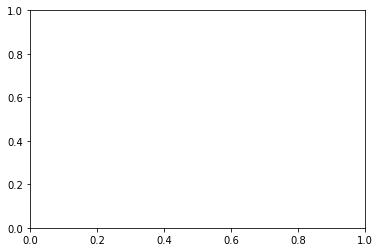

In [12]:
import matplotlib.pyplot as plt

plt.plot(epoch_list, train_loss_list, label='train_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend(loc='upper right')
plt.savefig("train_loss.png")
plt.gca().clear()

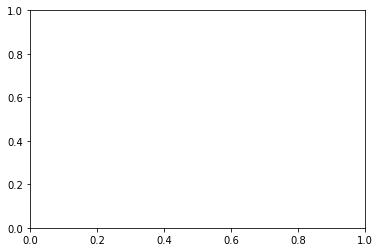

In [13]:
plt.plot(epoch_list, test_loss_list, label='test_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend(loc='upper right')
plt.savefig("test_loss.png")
plt.gca().clear()

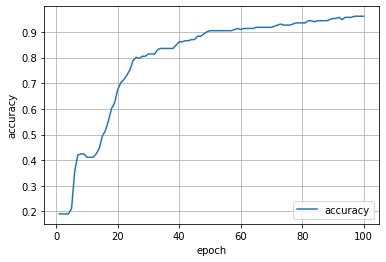

In [14]:
plt.plot(epoch_list, accuracy_list, label='accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.savefig("accuracy.png")

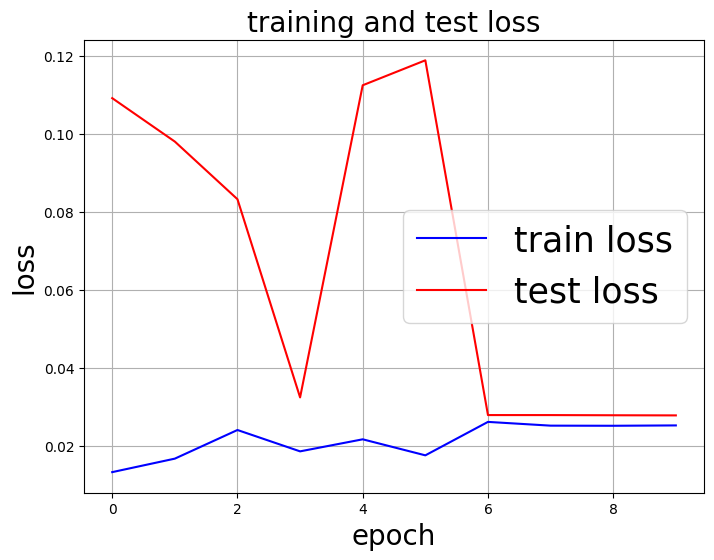

In [ ]:
import matplotlib.pyplot as plt

num_epochs=10
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.plot(range(num_epochs), train_loss_list, c='b', label='train loss')
ax.plot(range(num_epochs), test_loss_list, c='r', label='test loss')
ax.set_xlabel('epoch', fontsize='20')
ax.set_ylabel('loss', fontsize='20')
ax.set_title('training and test loss', fontsize='20')
ax.grid()
ax.legend(fontsize='25')
plt.show()

In [ ]:
model.load_state_dict(torch.load("cnn-9.model"))

model.eval()
correct=0
with torch.no_grad():
  for i, (images, labels) in enumerate(test_loader):
    images, labels = images, labels
    outputs = model(images)
    pred = outputs.argmax(dim=1, keepdim=True)
    correct += pred.eq(labels.view_as(pred)).sum().item()
  accuracy = correct / len(test_loader.dataset)
  print("Accuracy: " + str(accuracy))

Accuracy: 0.19480519480519481
